# Theory documentation for `pneumoinfer`

In [3]:
import sys
path = '/Users/Rob/work/pneumoinfer'
sys.path.append(path + '/source/') 
from pneumoinfer import pneumoinfer

import numpy as np
import pandas as pd
import scipy.special as spec
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

---

## Motivating background

Multi-state models - stochastic processes occupying one of a finite set of states at each moment in time - appear to describe many natural phenomena, but are probably most frequently used in the mathematical modelling of population health. The statistical inference (or selection) of these models for real-world applications frequently involves data in the form of a sequence of individual state observations, which are often coupled with some diagnostic uncertainty.

There are over 90 known capsular serotypes of _Streptococcus pneumoniae_, which persist despite their mutual competition for the same ecological niche (the nasopharynx) and a known fitness gradient. Motivated by the global pneumococcal disease burden, a specific class of multi-state models has been developed to describe the carriage dynamics which offers a neat explanation of this persistence through immunity-driven stabilisation effects (see [Cobey & Lipsitch (2012)](https://pubmed.ncbi.nlm.nih.gov/22383809/)). This class of model typically uses a counting memory of past state (or serotype) occupations (or colonisations) as a model for human immunity (see, e.g., [Flasche et al. (2013)](https://royalsocietypublishing.org/doi/10.1098/rspb.2013.1939) for an alternative formulation and [Løchen & Anderson (2020)](https://pubmed.ncbi.nlm.nih.gov/31055164/) for a general review of the carriage transmission models). Building from these mathematical models, a range of statistical approaches have also been used to infer the pneumococcal carriage through a given population from nasopharyngeal swab sample data (e.g., [Lipsitch et al. (2012)](https://pubmed.ncbi.nlm.nih.gov/22441543/) and [Numminen et al. (2013)](https://pubmed.ncbi.nlm.nih.gov/23822205/)). All of this is obviously really important, e.g., to understanding more precisely how a vaccine covering a restricted range of serotypes can impact colonisation in a given community or region. 

The design of policies for gathering data will always have a direct impact on the quality and utility of information that can be learned about a model via statistical inference. Therefore, it's typically useful to know _a priori_ the fundamental constraints a given policy might impose on this procedure. The purpose of the `pneumoinfer` class is to provide researchers with a rigorous framework to investigate these limitations for the inference of multi-state models with a counting memory - which are structurally inspired by the pneumococcus carriage models of [Cobey & Lipsitch (2012)](https://pubmed.ncbi.nlm.nih.gov/22383809/) and [Lipsitch et al. (2012)](https://pubmed.ncbi.nlm.nih.gov/22441543/). The framework should also useful in model inference with real data.

In this documentation, we're going to analyse the master equation of a stochastic model which includes memory effects from individual immunity and investigate a novel (to our knowledge) approximate ODE description for the dynamics, while assessing its validity. By then exploiting the new efficient ODE description, we will be able to develop a new method of inference that avoids biasing from overly large sampling windows; which is the main inference method implemented in the `pneumoinfer` class.

---

## The fixed $\Lambda_i$ model

Let's now construct a multi-state model which incorporates a counting memory of past state occupations. This will include: an event rate of state clearance $\tilde{\mu}_i$ - the rate at which an individual occupying the $i$-th indexed state returns to the null state; an event rate of susceptibility $\tilde{\Lambda}_i$ for an individual moving to the $i$-th state from the null state; and a state-specific factor matrix $f_{ii'}$ which rescales $\tilde{\Lambda}_{i'}$ to create an event rate for an individual moving directly between the $i$-th and $i'$-th states. 

Now consider $\tilde{\mu}_i=\tilde{\mu}_i( \dots, n_{i}, \dots )$, i.e., a function of all previous state occupations by the individual, where $n_i$ are the state-specific counts of past occupations. The rate $\tilde{\mu}_i$ hence maintains a 'record' of past state occupations and updates accordingly through this memory. Additionally, we will make each rate $\tilde{\Lambda}_i=\tilde{\Lambda}_i(n_{i})$, i.e., a function _only_ of the state-specific count associated to each rate, respectively. The choice in the latter case comes from interpreting the counting memory as a model for capsular immunity - this will also turn out to be quite important for our approximation further on.

Note that in [Cobey & Lipsitch (2012)](https://pubmed.ncbi.nlm.nih.gov/22383809/), the models of nonspecific and specific immunity suggest choosing the following functions

$$
\begin{align}
\tilde{\mu}_i( \dots, n_{i}, \dots ) &= \mu_{\rm max} + (\mu_i - \mu_{\rm max})\exp \bigg( -\epsilon \sum_{\forall i'}n_{i'} \bigg) \\
\tilde{\Lambda}_i(n_i) &= \Lambda_{i}{\bf 1}_{n_i=0} + \sigma \Lambda_{i}{\bf 1}_{n_i>0} \,.
\end{align}
$$

In the expressions above: $\epsilon$ governs the level of (immune system maturation) with respect to the number of past state occupations; ${\bf 1}_A$ denotes an indicator function whose argument is unity when $A$ is satisfied, else $0$; and the susceptibility of an individual is assumed to be reduced by a constant factor of $\sigma$ after having occupied that state once or more.

The multi-state process that we're going to consider would be normally be described as a non-Markovian phenomenon. However, the modelling approach we will take is instead a bit more similar to the formal concept of a Markov embedding (as studied, e.g., recently in [Kanazawa & Sornette (2021)](https://arxiv.org/abs/2102.00242)). By creating a binary state occupation variable $x_i$ for the $i$-th serotype, and the probability of occupying state $(\dots , x_i , \dots , n_i , \dots )$ at time $t$ as $P(\dots , x_i , \dots , n_i , \dots , t)$, we may write a Markovian master equation for the process. Let's now define

$$
\begin{align}
p_i(\dots ,n_i,\dots ,t) &\equiv P(\dots, x_{i}=1, x_{i'}=0, \dots ,n_{i},\dots ,t)\quad  \forall i'\neq i \\   
q(\dots ,n_i,\dots ,t) &\equiv P(\dots, x_{i}=0, \dots ,n_{i},\dots ,t) \quad \forall i\,.
\end{align}
$$

Using these definitions, it is straightforward to show that the master equation satisfies

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}p_i(\dots ,n_i,\dots ,t) &= \tilde{\Lambda}_i(n_i-1)q(\dots ,n_{i}-1,\dots ,t) + \sum_{\forall i' \neq i}f_{i'i}\tilde{\Lambda}_i (n_i-1)p_{i'}(\dots ,n_{i'}, n_i-1,\dots ,t) \\
&\quad - \tilde{\mu}_i( \dots, n_{i}, \dots ) p_i(\dots ,n_i,\dots ,t) - \sum_{\forall i'\neq i}f_{ii'}\tilde{\Lambda}_{i'} (n_{i'}) p_i(\dots ,n_i,\dots ,t) \\
\frac{{\rm d}}{{\rm d}t}q(\dots ,n_i,\dots ,t) &= \sum_{\forall i}\tilde{\mu}_i( \dots, n_{i}, \dots )p_i(\dots ,n_i,\dots ,t) - \sum_{\forall i}\tilde{\Lambda}_i(n_i) q(\dots ,n_i,\dots ,t) \,.
\end{align}
$$

By defining the state space to encode the memory of past state occupations using the $n_i$ values themselves, the process is Markovian over the full $(\dots , x_i,\dots ,n_i,\dots)$ space. Note also that one may obtain the time-dependent joint distribution over the $(\dots ,n_i,\dots)$ space, i.e., $P(\dots, n_i, \dots, t)$, through marginalisation at any time

$$
\begin{equation}
P(\dots, n_i, \dots, t) = q(\dots, n_i, \dots, t) + \sum_{\forall i} p_i(\dots, n_i, \dots, t) \,.   
\end{equation}
$$

Though we intend our analysis of this class of multi-state models to apply more generally beyond immediate applications to pneumococcus, it also is worth noting that restricting individuals to occupy a single state at a time only approximates the full pneumococcal carriage dynamics. The true process actually allows for some individuals to carry more than one serotype at at time. However, due to the relatively low and variable reported prevalence of simultaneous serotype carriers (or 'co-colonised' individuals) across different studies (see, e.g., [Gratten et al. (1989)](https://pubmed.ncbi.nlm.nih.gov/2639508/), [Huebner et al. (2000)](https://journals.lww.com/pidj/fulltext/2000/10000/lack_of_utility_of_serotyping_multiple_colonies.19.aspx) and many others...), the single-state occupation model should still a good tracer model of the underlying dynamical behaviour of the system. Note also that this additional complexity in the dynamics should be straightforward to incorporate into our framework for future analyses. 

Let's now try an approximation for the joint distributions of $p_i(\dots, n_i, \dots, t)$ and $q(\dots, n_i, \dots, t)$ which assumes separability, such that

$$
\begin{align}
\ p_i(\dots, n_i, \dots, t) &\simeq p_i(t)P(\dots, n_i, \dots, t) \\
\ q(\dots, n_i, \dots, t) &\simeq q(t)P(\dots, n_i, \dots, t) \,.
\end{align}
$$

We shall evaluate the quality of this approximation later on (so don't worry) under different parametric conditions, but for now, let's just treat it as an ansatz.

By marginalising over states in the master equation, then substituting in the approximations above, and finally marginalising (each a summation from $n_{i'}=0$ to $\infty$) over the resulting relation $\forall n_{i'} \,\, i'\neq i$, one finds that the following time evolution equation is separately satisfied by each marginal $P(n_i,t)$ distribution 

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(n_i,t) &= \bigg[ \tilde{\Lambda}_i(n_i-1)q(t) + \sum_{\forall i'\neq i}  f_{i'i}\tilde{\Lambda}_{i} (n_{i}-1) p_{i'}(t) \bigg] P(n_{i}-1,t) \\
&\quad - \bigg[ \tilde{\Lambda}_i(n_i)q(t) + \sum_{\forall i'\neq i} f_{ii'}\tilde{\Lambda}_{i'} (n_{i'}) p_i(t)\bigg] P(n_i,t) \,.
\end{align}
$$

In addition to the separability assumption, the key point which allowed us to derive this one-step marginal master equation was the dependence of $\tilde{\Lambda}_i$ on _only_ $n_i$; in contrast to all of the past recorded states $(\dots, n_i, \dots)$ like $\tilde{\mu}_i$.

From this point on we'll focus on the specific pneumococcus model by inserting the rate function definitions from [Cobey & Lipsitch (2012)](https://pubmed.ncbi.nlm.nih.gov/22383809/) that we introduced at the start into the marginal master equation for $P(n_i,t)$. The `pneumoinfer` class is currently written for only these models (i.e., with just these choices of function), but it's useful to see how the steps above could be performed for more general models too. The solution to the marginal master equation with these function substitutions is simply a Poisson distribution $P(n_i,t) = {\rm Poisson}[n_i;{\rm E}_t(n_i)]$, where

$$
\begin{equation}
{\rm E}_t (n_i) = {\rm E}_{t_{\rm init}}(n_i) + \int^t_{t_{\rm init}}{\rm d}t'\bigg[ \sigma \Lambda_iq(t') +\sum_{\forall i'\neq i}  f_{i'i}\sigma \Lambda_{i} p_{i'}(t')\bigg] \,.
\end{equation}
$$

Exploiting the properties of this Poisson distribution, if we now return to the full master equation and marginalise them over all $n_i$, while noting that

$$
\begin{align}
\ p_i(t) &= \sum_{\forall n_i}\sum_{n_{i}=0}^\infty p_i(\dots, n_i, \dots, t) \\
\ q(t) &= \sum_{\forall n_i}\sum_{n_{i}=0}^\infty q(\dots, n_i, \dots, t) \,,
\end{align}
$$

one arrives at the following finite (implicitly integro-differential) system

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}p_i(t) &= \Lambda_iF_{it} q(t) + \sum_{\forall i'\neq i} f_{i'i} \Lambda_iF_{it} p_{i'}(t) - \mu_iG_{it} p_i(t)-\sum_{\forall i'\neq i}f_{ii'}\Lambda_{i'}F_{i't} p_i(t) \\
\frac{{\rm d}}{{\rm d}t}q(t) &= \sum_{\forall i}\mu_iG_{it}p_i(t) - \sum_{\forall i}\Lambda_iF_{it}q(t)\,,
\end{align}
$$

where, to avoid repetition, we have defined

$$
\begin{align}
\ F_{it} &= P(n_i=0,t)+\sigma P(n_i>0,t) = e^{-{\rm E}_t(n_i)}+\sigma \big[ 1-e^{-{\rm E}_t(n_i)}\big] \\
\ G_{it} &= \frac{\mu_{\rm max}}{\mu_i} + \bigg( 1-\frac{\mu_{\rm max}}{\mu_i}\bigg) e^{\sum_{\forall i}{\rm E}_t(n_i)(e^{-\epsilon}-1)}\,, 
\end{align}
$$

where to derive $G_{it}$ we have had to assume conditional independence between $n_i$ and $n_{i'}\,\,\forall i'\neq i$. The equation for ${\rm E}_t (n_i)$ can be differentiated to provide an equation for the time derivative of ${\rm E}_t(n_i)$ - evolving this equation alongside the system defined above yields an explicit finite ODE system. Note also that this approximation technique should apply to other forms of memory functions used for $\tilde{\mu}_i(\dots, n_i, \dots)$ and $\tilde{\Lambda}_i(n_i)$ by simply marginalising over their $n_i$ values, and so this approximate approach appears to be quite generalisable to other simlar systems.

In order to analyse the system properties and check the validity of the approach above, we're now going to make some decisions about the parameter space to explore. Let's independently draw the $(\mu_i,\Lambda_i)$ values from Gamma distributions with shapes $(\mu_\alpha,\Lambda_\alpha)$ and rates $(\mu_\beta,\Lambda_\beta)$. Let's also constrain the matrix values $f_{ii'}=f_{i}{\bf I}_{i'}$ (where ${\bf I}_{i'}$ denotes the elements of a simple vector of ones) which also happens to be consistent with pneumococcus data anyway (see, e.g., [Lipsitch et al. (2012)](https://pubmed.ncbi.nlm.nih.gov/22441543/)). We'll also need a metric of comparison between the marginalised distribution outputs from the fully simulated master equation and our approximation. To this end, it probably makes sense to look at the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the marginal distributions for $x_i$ and $n_i$ in a full stochastic simulation and our approximation. In other words

$$
\begin{align}
\ D^{(x)}_{{}_{\rm KL}} &= \sum_{\forall i} p_{i, {\rm sim}}(t) \ln \Bigg[ \frac{p_{i, {\rm sim}}(t)}{p_i(t)} \Bigg]  \\ 
&\simeq - \sum_{\forall i} \frac{\ln Z_{\rm sim}(x_i, t)}{Z_{\rm sim}(x_i, t)} -\sum_{\forall i} \frac{\ln p_i(t)}{Z_{\rm sim}(x_i, t)} \\
\ D^{(n_i)}_{{}_{\rm KL}} &= \sum_{n_i=0}^{\infty} P_{\rm sim}(n_i, t) \ln \Bigg[ \frac{P_{\rm sim}(n_i, t)}{P(n_i,t)} \Bigg] \\ 
&\simeq - \sum_{n_i=0}^{\infty}\frac{\ln Z_{\rm sim}(n_i, t)}{Z_{\rm sim}(n_i, t)} - \sum_{n_i=0}^{\infty} \frac{\ln {\rm Poisson}[n_i;{\rm E}_t(n_i)]}{Z_{\rm sim}(n_i, t)} \\
&\simeq - \sum_{n_i=0}^{\infty}\frac{\ln Z_{\rm sim}(n_i, t)}{Z_{\rm sim}(n_i, t)} - \sum_{n_i=0}^{\infty} \bigg[ \frac{n_i\ln {\rm E}_t(n_i) - {\rm E}_t(n_i) - \ln \Gamma (n_i+1)}{Z_{\rm sim}(n_i, t)} \bigg] \,,
\end{align}
$$

where $Z_{\rm sim}(x_i, t)$ and $Z_{\rm sim}(n_i, t)$ denote the marginal frequency counts in each state space derived from a stochastic simulation of the master equation. Note that for the whole $(\dots, n_i, \dots)$ space, a better comparison would involve Monte Carlo integration of the joint counts $Z_{\rm sim}(\dots, n_i, \dots, t)$. However, this is quite a lot more challenging with many dimensions (usually necessitating nested sampling) and so we'll consider it to be beyond the present scope. 

Using the `run_sim` method of the `pneumoinfer` class, and the equations above, we can generate numerically-approximate plots of the Kullback-Leibler divergence on the marginal distributions over a range of numbers of states, parameters and points in time.

In [21]:
nstat = 10
pn = pneumoinfer(nstat)
kmu = 1.0
pn.create_members(
    1, 
    {
        'Curr'  : 0,
        'npast' : np.zeros(nstat),
        'Lam'   : np.random.gamma(kmu,1.0/kmu,size=nstat),
        'mu'    : np.random.gamma(kmu,1.0/kmu,size=nstat),
        'f'     : np.random.gamma(kmu,1.0/kmu,size=nstat),
        'eps'   : 1.0/5.0,
        'sig'   : 1.0,
        'mumax' : 1.0
    }
)
nreals = 10000
times = [0.2*float(i) + 0.1 for i in range(0,40)]
pn.run_ode(20.0,0.001)
pn.run_sim(nreals,10.0,0.01,time_snaps=times)
DKLx, DKLn = [], []
for t in times:
    counts = pd.Series(pn.sim_output['Curr'][t].flatten()).value_counts()
    co = np.zeros(nstat + 1)
    co[counts.index.values.astype(int)] = counts.values
    co = co[1:]
    it = np.argmin((pn.ode_output['time']-t)**2)
    DKLx.append(
        - np.sum(np.log(co[co>0])/co[co>0])
        - np.sum(np.log(pn.ode_output['probCurr'][it][co>0])/co[co>0])
    )
    DKLnsum = 0.0
    for i in range(0,nstat):
        ncounts = pd.Series(pn.sim_output['npastsum'][t][i].flatten()).value_counts()
        nco = np.zeros(1000)
        ns = np.arange(0, 1000, 1)
        nco[ncounts.index.values.astype(int)] = ncounts.values
        DKLnsum += (
            - np.sum(np.log(nco[nco>0])/nco[nco>0]) 
            - np.sum(ns[nco>0] * np.log(pn.ode_output['Expnpast'][it][i])/nco[nco>0])
            + np.sum(pn.ode_output['Expnpast'][it][i]/nco[nco>0])
            + np.sum(spec.loggamma(ns[nco>0]+1)/nco[nco>0])
        )
    DKLn.append(DKLnsum)

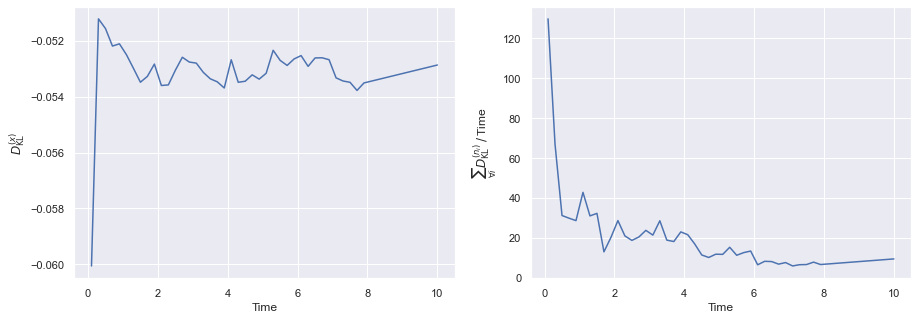

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(times,DKLx)
ax[1].plot(times,np.asarray(DKLn)/np.asarray(times))
ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$D^{(x)}_{\rm KL}$')
ax[1].set_xlabel('Time')
ax[1].set_ylabel(r'$\sum_{\forall i}D^{(n_i)}_{\rm KL}\,/\,$Time')
plt.show()

Interestingly, there is more significant deviation at the beginning of the simulation in the case of the $n_i$ values (when rescaled with time). Conversely, the $x_i$ comparison seems more stable over time.

---

## A varying $\Lambda_{iu}$ model

We're now ready to introduce an alternative model which accounts for a stochastically-varying susceptibility $\Lambda_{iu}$ (a possible model for community exposure to infectious individuals), which is now additionally indexed by '$u$' which corresponds to each individual. In this model, we have 

$$
\begin{equation}
\Lambda_{iu} = \Lambda_{\rm min} + \lambda\sum_{\forall u'\neq u}\beta_{uu'} \frac{x_{iu'}}{N_{\rm p}}\,,
\end{equation}
$$

where: the total population number is $N_{\rm p}$; $\beta_{uu'}$ are elements of a 'contact matrix' which rescales the event rate according to the spreading behaviour between the $u$-th and $u'$-th individuals; $\lambda$ is a constant normalisation for $\beta_{uu'}$; and $x_{iu'}$ records the state of the $u'$-th individual.

Extending the master equation we introduced in the previous section to include the susceptibility above and the states of $N_{\rm p}$ individuals, one can easily adapt the argument of the previous section to arrive at the following generalisation of the ODE system we found earlier

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}p_{iu}(t) &= {\rm E}_t(\Lambda_{iu})F_{it} q_u(t) + \sum_{\forall i'\neq i} f_{i'i} {\rm E}_t(\Lambda_{iu})F_{it} p_{i'u}(t) - \mu_iG_{it} p_{iu}(t)-\sum_{\forall i'\neq i}f_{ii'}{\rm E}_t(\Lambda_{i'u})F_{i't} p_{iu}(t) \\
\frac{{\rm d}}{{\rm d}t}q_u(t) &= \sum_{\forall i}\mu_iG_{it}p_{iu}(t) - \sum_{\forall i}{\rm E}_t(\Lambda_{iu})F_{it}q_u(t)\,.
\end{align}
$$

In the equations above, the state occupation probabilities of separate $u$-indexed individuals (or $u$-indexed categories of individual) are $p_{iu}(t)$ and $q_u(t)$, and we've also computed the expectation

$$
\begin{equation}
{\rm E}_t(\Lambda_{iu}) = \Lambda_{\rm min} + \lambda\sum_{\forall u'\neq u}\beta_{uu'} \frac{p_{iu'}(t)}{N_{\rm p}}\,.
\end{equation}
$$

#### Code this up and more testing plots needed for this section too....

---

## Computing the log-likelihood and testing the inference

#### Rewrite this section to be more general, e.g., so that it includes $p_{iu}(t)$ and accomodates for varying FOI too...

We're now ready to apply our ODE approximation to the statistical inference of the full simulation. The goal, therefore, will be to infer the posterior distribution ${\cal P}$ over the parameter vector $\Theta$ corresponding to each of the models we talked about earlier. We're going to assume that all data sets considered come in the form of a sequence of state observations (or longitudinally-monitored swab samples if you're talking about pneumococcus) for each sampled individual from the population which takes the form of counts, times and associated sample sizes ${\cal D}\equiv \{d_c,d_t,d_s\}$ (where $d_c=\{c_{ij}\}$, $d_t=\{t_j \, : \, t_{\rm init}<t_j\leq t_{\rm end}\}$ and $d_s=\{s_j\}$). Note that this sequence of state observations may also be regarded as a form of _filtration_ of the underlying stochastic process. Given a likelihood ${\cal L}$ of ${\cal D}$, these time intervals are independent of each other and so one may decompose ${\cal L}$ for the whole population as follows

$$
\begin{equation}
\ {\cal L}({\cal D} \vert \Theta , t_{\rm init}, t_{\rm end}) = {\cal L}(t_{\rm init} \vert \Theta )\prod_{\forall j \, : \, t_j\,\in \,d_t}{\cal L}( t_j \vert \Theta , t_{j-1}) \,,
\end{equation}
$$

where for the first observation, $t_1$, one sets $t_0=t_{\rm init}$ and the last observation is defined at $t_{\rm end}$. The ODE solution then allows us to easily compute the multinomial likelihoods for the initial condition and into the future

$$
\begin{align}
{\cal L}(t_{\rm init} \vert \Theta ) &= \frac{\Gamma (s_0+1)}{\prod_{\forall i}\Gamma (c_{i0}+1)}q(t_{\rm init})^{s_0-\sum_{\forall i}c_{i0}} \prod_{\forall i}p_i(t_{\rm init})^{c_{i0}}\\
{\cal L}( t_j \vert \Theta , t_{j-1}) &= \frac{\Gamma (s_j+1)}{\prod_{\forall i}\Gamma (c_{ij}+1)}q(t_j)^{s_j-\sum_{\forall i}c_{ij}} \prod_{\forall i}p_i(t_j)^{c_{ij}} \,.
\end{align}
$$

#### Point out that the independence of second expression above with respect to $t_{j-1}$ is not trivial and relies on our Markovian description



---

## Additional notes: a method to compute the gradient of the log-likelihood

The current version of `pneumoinfer` does not support a gradient calculation for the log-likelihood (mainly because I was eager to move onto some other stuff!). However, to assist anyone wanting to implement this themselves, I thought it would be helpful to go through the calculation which computes the gradient (in principle) without resorting to numerical derivatives. This makes use of the 'multiple-adjoint' method as implemented in [Zhuang et al. (2021)](https://arxiv.org/abs/2006.02493). Consider the following 'data Lagrangian'

$$
\begin{align}
L &=  \ln{\cal L}(t_{\rm init} \vert \Theta )+ \sum_{\forall j \, : \, t_j\,\in \,d_t} L_j\\
L_j &= \ln{\cal L}( t_j \vert \Theta , t_{j-1}) + \int^{t_{j}}_{t_{j-1}}{\rm d}t \,{\sf h}(t)^{\rm T}\bigg[ \frac{{\rm d}}{{\rm d}t}{\sf V}(t) - {\sf M}_\Theta (t)\bigg] \\
&= \ln{\cal L}( t_j \vert \Theta , t_{j-1}) + {\sf h}(t_j)^{\rm T}{\sf V}(t_j)-{\sf h}(t_{j-1})^{\rm T}{\sf V}(t_{j-1}) - \int^{t_{j}}_{t_{j-1}}{\rm d}t \bigg[\frac{{\rm d}}{{\rm d}t}{\sf h}(t)^{\rm T} {\sf V}(t) + {\sf h}(t)^{\rm T}{\sf M}_\Theta (t)\bigg] \,,
\end{align}
$$

where ${\sf V}(t)=[\dots, {\rm E}_t(n_i),\dots, p_i(t), \dots , q(t)]^{\rm T}$, ${\sf h}(t)$ is a dynamical vector of Lagrange multipliers and ${\sf M}_\Theta (t)$ is just compact notation for the vector of ODE terms on the RHS. Varying $L_j$ with respect to the boundary condition ${\sf V}(t_j)$ and ${\sf V}(t)$, we obtain the constraints

$$
\begin{align}
\frac{\partial L_j}{\partial {\sf V}(t_j)} &= 0 \quad \Longleftrightarrow \quad \frac{\partial}{\partial {\sf V}(t_j)}\ln{\cal L}( t_j \vert \Theta , t_{j-1}) + {\sf h}(t_j ) = 0 \\
\frac{\delta L_j}{\delta {\sf V}(t)} &= 0 \quad \Longleftrightarrow \quad \frac{{\rm d}}{{\rm d}t}{\sf h}(t) + \bigg[\frac{\partial}{\partial {\sf V}(t)}{\sf M}_\Theta (t)\bigg]^{\rm T}{\sf h}(t) = 0\,,
\end{align}
$$

Let us also note that if we vary $L_j$ with respect to $\Theta$ and optimise the likelihood, one obtains

$$
\begin{align}
\frac{\partial L_j}{\partial \Theta} &= \frac{\partial}{\partial \Theta}\ln{\cal L}( t_j \vert \Theta , t_{j-1}) - \int^{t_{j}}_{t_{j-1}}{\rm d}t \,{\sf h}(t)^{\rm T}\frac{\partial}{\partial \Theta}{\sf M}_\Theta (t) \\
&\underset{{\rm opt}}{\longrightarrow} \int_{t_{j}}^{t_{j-1}}{\rm d}t \,{\sf h}(t)^{\rm T}\frac{\partial}{\partial \Theta}{\sf M}_\Theta (t)\,.
\end{align}
$$

#### Method proposed from here is:
- #### Treat values of ${\rm E}_{t_{\rm init}}(n_i)$ as a prior that should be varied (draw values from a Gamma distribution to investigate the importance of this prior on the end results) 
- #### From the initialised states of the set of individuals run the forward ODE in time to obtain the value of $\frac{\partial}{\partial \Theta}{\sf M}_\Theta (t)$ at every observed timestep in the sampling scheme
- #### For each interval edge determine ${\sf h}(t_j)$ using the top equation and the forward-time likelihood
- #### For each interval solve the second equation to get its backward-time trajectory ${\sf h}(t)$ 
- #### Integrate over ${\sf h}(t)$ and $\frac{\partial}{\partial \Theta}{\sf M}_\Theta (t)$ to determine the gradient in the last expression